In [1]:
import pm4py, os, datetime

#import event logs
if __name__ == "__main__":
    log = pm4py.read_xes('BPI_Challenge_2019-3-w-after.xes')

parsing log, completed traces ::   0%|          | 0/15182 [00:00<?, ?it/s]

# Preprocessing

## Filter Definition

Used filters:

timeFrame filtering:
- filter out events not in [2018-01-0 ; 2019-01-28]
- implemented in filter_timeframe()

seperation of documentTypes:
- seperate traces into 3 event logs, one for each documentType
- implemented in group_by_documentType()

removal of incomplete cases:
- removes traces, that have not one of the specified start and end-activities
- EC Purchase order: 
    - Start Events: "Create Purchase Order Item", "Create Purchase Requisition Item", "SRM: Created", "Vendor creates invoice"
    - End Events: "Clear Invoice", "Delete Purchase Order Item"
- Framework order: 
    - Start Events: "Create Purchase Order Item", "Create Purchase Requisition Item", "Vendor creates invoice"
    - End Events: "Clear Invoice", "Delete Purchase Order Item"
- Standard PO: 
    - Start Events: "Create Purchase Order Item", "Create Purchase Requisition Item", "Vendor creates invoice"
    - End Events: "Clear Invoice", "Delete Purchase Order Item"

## General Preprocessing Methods

In [2]:
# helper function to print traces in a nice, readable way
def print_trace(trace):
    trace_string = ""
    for trace_idx, event in enumerate(trace):
        if trace_idx != 0:
            trace_string += ", "
        trace_string += event['concept:name']
    print(trace_string)  

# exclude all traces that are not between 2018-01-0 and 2019-01-28
def filter_timeframe(log):
    return pm4py.filter_time_range(log, "2018-01-01 00:00:00", "2019-01-28 23:59:59", mode='traces_contained')

# group the eventlog by the values of the documentType attribute
def group_by_documentType(log):
    log_ecPurchaseOrder = pm4py.filter_trace_attribute_values(log, "(case) Document Type", ["EC Purchase order"], retain = True)
    log_frameworkOrder = pm4py.filter_trace_attribute_values(log, "(case) Document Type", ["Framework order"], retain = True)
    log_standardPO = pm4py.filter_trace_attribute_values(log, "(case) Document Type", ["Standard PO"], retain = True)
    return log_ecPurchaseOrder, log_frameworkOrder, log_standardPO


# removes traces, that have not one of the specified start and end-activities
def remove_incomplete_cases(log_ecPurchaseOrder, log_frameworkOrder, log_standardPO):
    
    # EC Purchase order
    log_ecPurchaseOrder = pm4py.filter_start_activities(log_ecPurchaseOrder, ["Create Purchase Order Item",
                    "Create Purchase Requisition Item", "SRM: Created", "Vendor creates invoice"])
    log_ecPurchaseOrder = pm4py.filter_end_activities(log_ecPurchaseOrder, ["Clear Invoice", "Delete Purchase Order Item"])
    
    # Framework order
    log_frameworkOrder = pm4py.filter_start_activities(log_frameworkOrder, ["Create Purchase Order Item",
                    "Create Purchase Requisition Item", "Vendor creates invoice"])
    log_frameworkOrder = pm4py.filter_end_activities(log_frameworkOrder, ["Clear Invoice", "Delete Purchase Order Item"])
    
    # Standard PO
    log_standardPO = pm4py.filter_start_activities(log_standardPO, ["Create Purchase Order Item",
                    "Create Purchase Requisition Item", "Vendor creates invoice"])
    log_standardPO = pm4py.filter_end_activities(log_standardPO, ["Clear Invoice", "Delete Purchase Order Item"])
    
    return log_ecPurchaseOrder, log_frameworkOrder, log_standardPO

# write event log to a xes file in the preprocessed directory
def write_log_to_file(log, filename):
    path = os.path.join(os.path.dirname(os.getcwd()), filename)
    pm4py.write_xes(log, path)
    
### splits the input log into compliant and incompliant traces ###
def split_by_compliance(log):
    
    compliant_ids = []
    
    for trace in log:
        
        goods_receipt = []
        invoice_receipt = []
        
        sum_goods_receipt = 0
        sum_invoice_receipt = 0
        
        # safe indices of goods_receipt and invoice_receipt;
        # caluculate sum(goods_receipt) and sum(invoice_receipt)
        for event_idx, event in enumerate(trace):
            if event['concept:name'] == 'Record Goods Receipt':
                goods_receipt.append(event_idx)
                sum_goods_receipt += event['Cumulative net worth (EUR)']
            elif event['concept:name'] == 'Record Invoice Receipt':
                invoice_receipt.append(event_idx)
                sum_invoice_receipt += event['Cumulative net worth (EUR)']
            elif event['concept:name'] == 'Cancel Goods Receipt':
                sum_goods_receipt -= event['Cumulative net worth (EUR)']
            elif event['concept:name'] == 'Cancel Invoice Receipt':
                sum_invoice_receipt -= event['Cumulative net worth (EUR)']
        
        # goods_receipt and invoice_receipt occured both at least once
        if goods_receipt and invoice_receipt:
            
            # First good Receipt before first Invoice Receipt
            # and last Invoice Receipt after last good Receipt
            if goods_receipt[0] < invoice_receipt[0] and goods_receipt[-1] < invoice_receipt[-1]:
                
                # sum(invoice_receipt) is in range of +-5% of sum(goods_receipt)
                goodwill = sum_goods_receipt * 0.05
                if sum_invoice_receipt > sum_goods_receipt - goodwill and sum_invoice_receipt < sum_goods_receipt + goodwill:
                    compliant = True
                else:
                    compliant = False
            else:
                compliant = False
        else:
            compliant = False
        
        # safe compliant traces in list compliant_ids
        if compliant:
            compliant_ids.append(trace._get_attributes()['concept:name'])
    
    # filter for the comliant traces
    compliant_log = pm4py.filtering.filter_trace_attribute_values(log=log, attribute_key='concept:name',
                                                                  values=compliant_ids, retain=True)
    # filter out comliant traces
    uncompliant_log = pm4py.filtering.filter_trace_attribute_values(log=log, attribute_key='concept:name',
                                                                  values=compliant_ids, retain=False)
    return compliant_log, uncompliant_log

## General Preprocessing Pipeline
1. timeFrame filtering
2. groupBy documentType
3. remove incomplete cases

In [3]:
### General Preprocessing ###

# 1. Filter on timeframe
filtered_log = filter_timeframe(log)

# 2. Group by documentType
log_ecPurchaseOrder, log_frameworkOrder, log_standardPO = group_by_documentType(filtered_log)

# 3. Remove incomplete cases
log_ecPurchaseOrder, log_frameworkOrder, log_standardPO = remove_incomplete_cases(log_ecPurchaseOrder, log_frameworkOrder, log_standardPO)

## Preprocessing for Compliance-Checking

### Preprocessing Pipeline:
1. timeFrame filtering
2. groupBy documentType
3. remove incomplete cases
4. Filter out variants: ["Create Purchase Order Item", "Delete Purchase Order Item"]
5. Seperate compliant and incompliant cases


abbreviations: "cumulative Net worth" = "cNw"
### Compliance Rules:
- First good Receipt before first Invoice Receipt
- Last Invoice Receipt after last good Receipt
- sum(Create Invoice Receipt. cNw) - sum(Delete Invoice Receipt.cNw) = sum(Create Good Receipt.cNw) - sum(Delete Goods Receipt.cNw) 
--> deviation is okay (5%)

#### Preprocessing Methods for Compliance-Checking

In [4]:
#filter out variants, that only consist of events:
#     "Create Purchase Order Item", "Delete Purchase Order Item"
def filter_out_cpoi_dpoi(log):
    return pm4py.filter_variants(log, [["Create Purchase Order Item", "Delete Purchase Order Item"]], retain=False)

#### Running Preprocessing for Compliance-Checking

In [5]:
# 4. filter out variants: ["Create Purchase Order Item", "Delete Purchase Order Item"]
log_ecPurchaseOrder_3wayMatch = filter_out_cpoi_dpoi(log_ecPurchaseOrder)
log_frameworkOrder_3wayMatch = filter_out_cpoi_dpoi(log_frameworkOrder)
log_standardPO_3wayMatch = filter_out_cpoi_dpoi(log_standardPO)

# write filtered logs to files for 3-way Matching
write_log_to_file(log_ecPurchaseOrder_3wayMatch, 'Preprocessed\\EC Purchase order_3wayMatching.xes')
write_log_to_file(log_frameworkOrder_3wayMatch, 'Preprocessed\\Framework order_3wayMatching.xes')
write_log_to_file(log_standardPO_3wayMatch, 'Preprocessed\\Standard PO_3wayMatching.xes')

exporting log, completed traces ::   0%|          | 0/346 [00:00<?, ?it/s]

exporting log, completed traces ::   0%|          | 0/232 [00:00<?, ?it/s]

exporting log, completed traces ::   0%|          | 0/8740 [00:00<?, ?it/s]

In [6]:
### 5. Seperate compliant and incompliant cases ###

# EC Purchase order
log_ecPurchaseOrder_compliant, log_ecPurchaseOrder_uncompliant = split_by_compliance(log_ecPurchaseOrder_3wayMatch)
write_log_to_file(log_ecPurchaseOrder_compliant, 'Compliance_3wayMatching\\EC Purchase order_compliant.xes')
write_log_to_file(log_ecPurchaseOrder_uncompliant, 'Compliance_3wayMatching\\EC Purchase order_uncompliant.xes')

# Framework order
log_frameworkOrder_compliant, log_frameworkOrder_uncompliant = split_by_compliance(log_frameworkOrder_3wayMatch)
write_log_to_file(log_frameworkOrder_compliant, 'Compliance_3wayMatching\\Framework order_compliant.xes')
write_log_to_file(log_frameworkOrder_uncompliant, 'Compliance_3wayMatching\\Framework order_uncompliant.xes')

# Standard PO
log_standardPO_compliant, log_standardPO_uncompliant = split_by_compliance(log_standardPO_3wayMatch)
write_log_to_file(log_standardPO_compliant, 'Compliance_3wayMatching\\Standard PO_compliant.xes')
write_log_to_file(log_standardPO_uncompliant, 'Compliance_3wayMatching\\Standard PO_uncompliant.xes')

exporting log, completed traces ::   0%|          | 0/332 [00:00<?, ?it/s]

exporting log, completed traces ::   0%|          | 0/14 [00:00<?, ?it/s]

exporting log, completed traces ::   0%|          | 0/174 [00:00<?, ?it/s]

exporting log, completed traces ::   0%|          | 0/58 [00:00<?, ?it/s]

exporting log, completed traces ::   0%|          | 0/7503 [00:00<?, ?it/s]

exporting log, completed traces ::   0%|          | 0/1237 [00:00<?, ?it/s]

# Process Discovery

## Preprocessing Pipeline
1. timeFrame filtering
2. groupBy documentType
3. remove incomplete cases
4. Filter out incompliant cases
5. filter out infrequent variants
6. Filter out SRM process


## Filter Definitions

filtering out infrequent variants:
- remove variants, that only consist of one single case
- implemented in filter_out_infrequent_variants()

filtering out incompliant cases:
- uses the method split_by_compliance() defined previously
- filter out incompliant traces and returns only compliant cases for the 3 document-types

## Preprocessing Methods for Process Discovery

In [7]:
# removes variants, that only consist of one single case
def filter_out_infrequent_variants(log_ecPurchaseOrder, log_frameworkOrder, log_standardPO):
    
    # EC Purchase order
    log_ecPurchaseOrder = pm4py.filter_variants_by_coverage_percentage(log_ecPurchaseOrder, 2/len(log_ecPurchaseOrder))
    
    # Framework order
    log_frameworkOrder = pm4py.filter_variants_by_coverage_percentage(log_frameworkOrder, 2/len(log_frameworkOrder))
    
    # Standard PO
    log_standardPO = pm4py.filter_variants_by_coverage_percentage(log_standardPO, 2/len(log_standardPO))
    
    return log_ecPurchaseOrder, log_frameworkOrder, log_standardPO

# filters out incompliant traces and returns only compliant cases for the 3 document-types
def filter_out_incompliant_cases(log_ecPurchaseOrder, log_frameworkOrder, log_standardPO):

    # EC Purchase order
    log_ecPurchaseOrder, uncompliant_temp = split_by_compliance(log_ecPurchaseOrder)

    # Framework order
    log_frameworkOrder, uncompliant_temp = split_by_compliance(log_frameworkOrder)

    # Standard PO
    log_standardPO, uncompliant_temp = split_by_compliance(log_standardPO)

    del uncompliant_temp
    return log_ecPurchaseOrder, log_frameworkOrder, log_standardPO

# seperate the SRM-process from the EC Purchase order process
def filter_srm_process(log):
    srm_events = ['SRM: Created', 'SRM: Incomplete','SRM: Held', 'SRM: Complete', 'SRM: Awaiting Approval',
                  'SRM: Document Completed', 'SRM: In Transfer to Execution System', 'SRM: Ordered',
                  'SRM: Deleted', 'SRM: Change was Transmitted', 'SRM: In Transfer to Execution Syst.']
    log_srm = pm4py.filtering.filter_event_attribute_values(log=log, attribute_key='concept:name', values=srm_events,
                                                        level='event', retain=True)
    log_ecPurchaseOrder = pm4py.filtering.filter_event_attribute_values(log=log, attribute_key='concept:name', values=srm_events,
                                                        level='event', retain=False)
    return log_srm, log_ecPurchaseOrder

## Running Preprocessing for Process Discovery

In [8]:
##4.##  Filter out incompliant cases
log_ecPurchaseOrder, log_frameworkOrder, log_standardPO = filter_out_incompliant_cases(log_ecPurchaseOrder,
                                                                                log_frameworkOrder, log_standardPO)

##5.## Filter out infrequent variants
log_ecPurchaseOrder, log_frameworkOrder, log_standardPO = filter_out_infrequent_variants(log_ecPurchaseOrder, log_frameworkOrder, log_standardPO)

##6.## Filter out SRM process
# filter for srm process
log_srm, log_ecPurchaseOrder = filter_srm_process(log_ecPurchaseOrder)

# write filtered logs to files
write_log_to_file(log_srm, 'Preprocessed\\SRM.xes')
write_log_to_file(log_ecPurchaseOrder, 'Preprocessed\\EC Purchase order_discovery.xes')
write_log_to_file(log_frameworkOrder, 'Preprocessed\\Framework order_discovery.xes')
write_log_to_file(log_standardPO, 'Preprocessed\\Standard PO_discovery.xes')

exporting log, completed traces ::   0%|          | 0/231 [00:00<?, ?it/s]

exporting log, completed traces ::   0%|          | 0/231 [00:00<?, ?it/s]

exporting log, completed traces ::   0%|          | 0/69 [00:00<?, ?it/s]

exporting log, completed traces ::   0%|          | 0/7108 [00:00<?, ?it/s]

## Methods for Process Discovery

In [9]:
# mine petri-net, display it and safe it as png    
def mine_petri_net(log, noise_threshold, save_file_name):
    # mine petrinet with inductive miner
    net, initial_marking, final_marking = pm4py.discovery.discover_petri_net_inductive(log, noise_threshold = noise_threshold)
    
    #view petrinet
    pm4py.view_petri_net(net, initial_marking, final_marking)
    print(save_file_name + "\n\n\n\n")
    
    # export petrinet to png file
    path = os.path.join(os.path.dirname(os.getcwd()), "Process Discovery\\Inductive Miner", save_file_name)
    pm4py.vis.save_vis_petri_net(net, initial_marking, final_marking, path)
    

# mine bpmn-model, display it and safe it as png
def mine_bpmn(log, noise_threshold, save_file_name):
    
    # mine bpmn with inductive miner
    bpmn = pm4py.discovery.discover_bpmn_inductive(log, noise_threshold)

    # view bpmn
    pm4py.vis.view_bpmn(bpmn)
    print(save_file_name + "\n\n\n\n")

    # export bpmn to png file
    path = os.path.join(os.path.dirname(os.getcwd()), "Process Discovery\\Inductive Miner", save_file_name)
    pm4py.vis.save_vis_bpmn(bpmn, path)

## Running Process Discovery

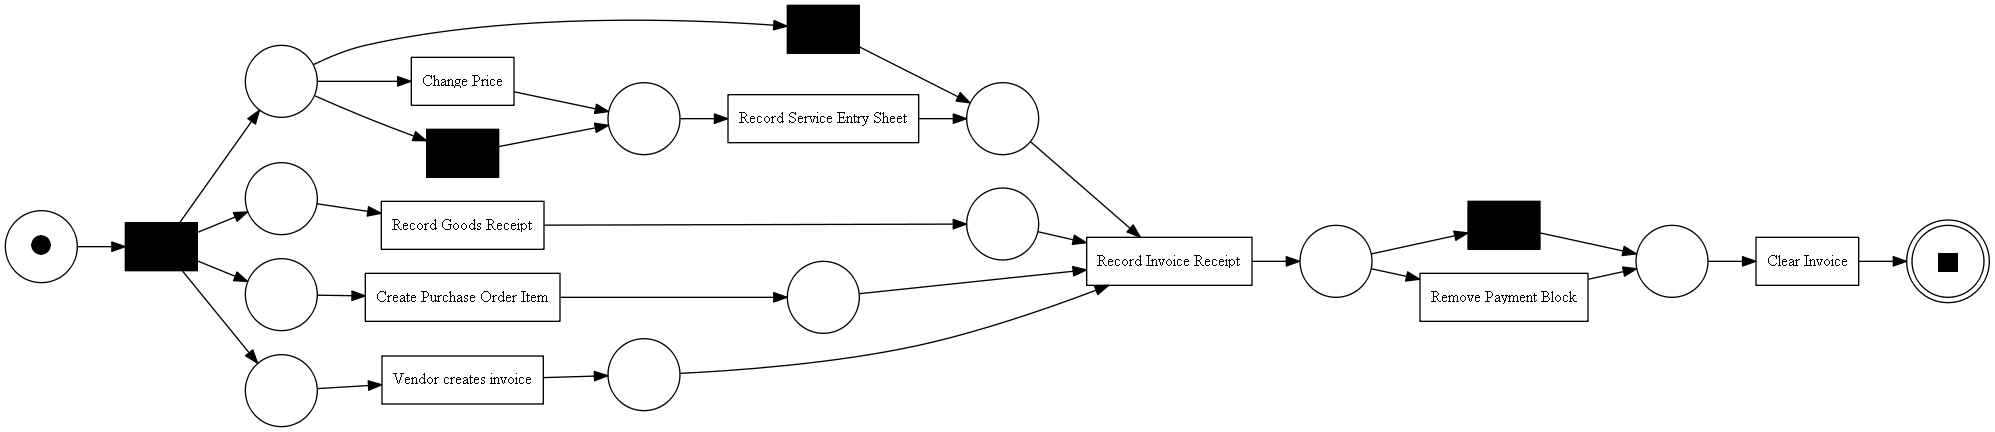

petriNet_ecPurchaseOrder.png






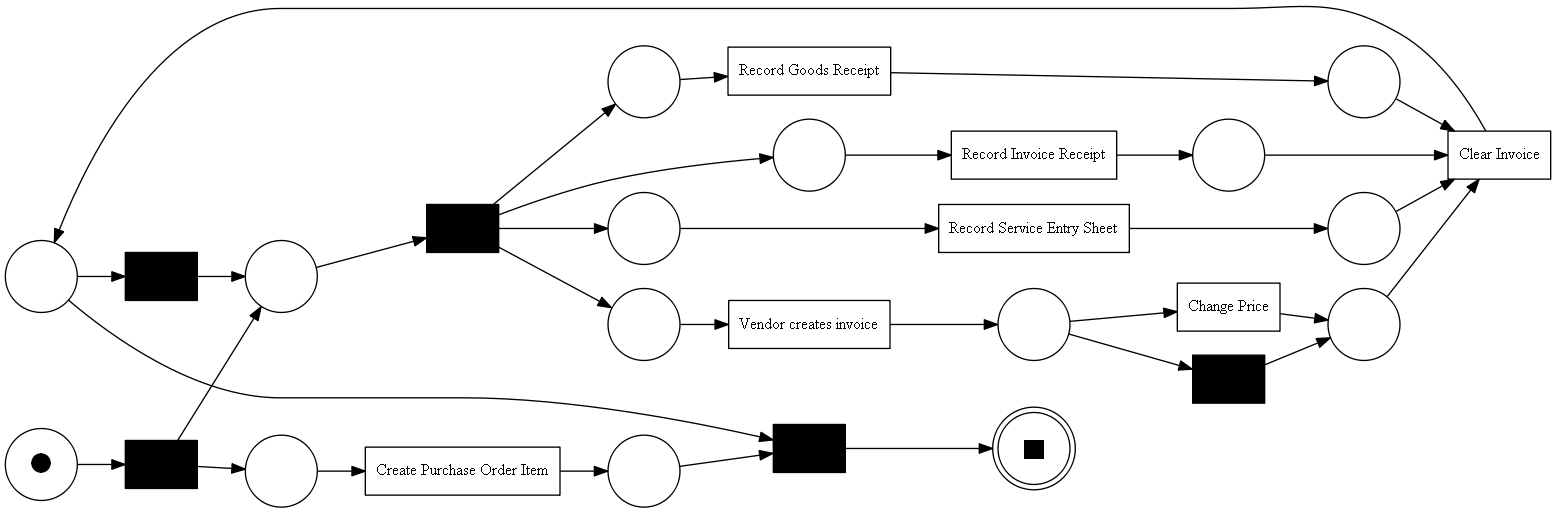

petriNet_frameworkOrder.png






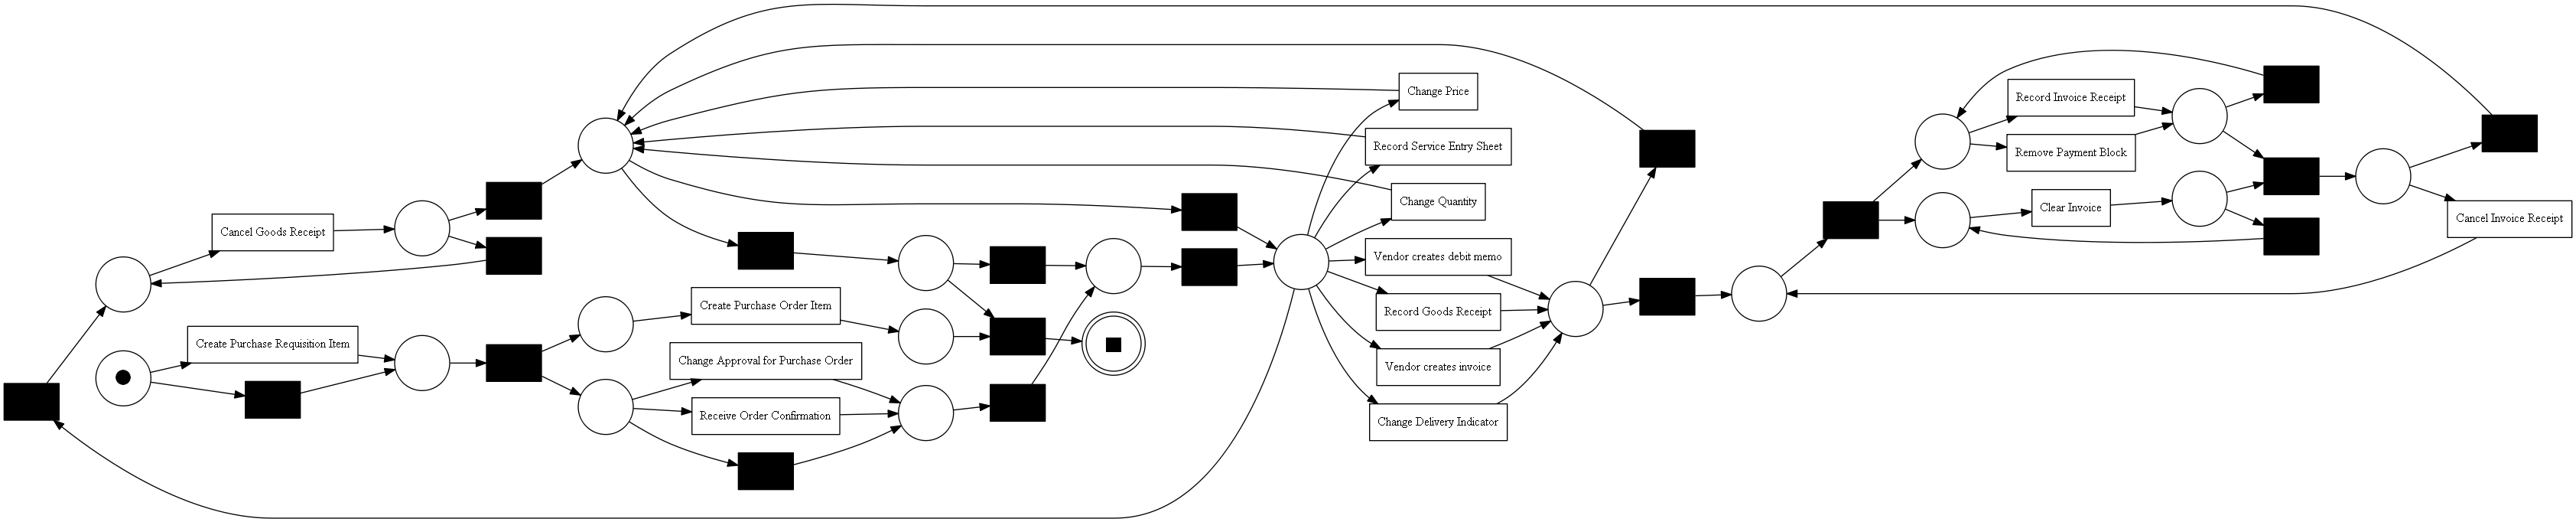

petriNet_standardPO.png






In [11]:
# Mine Petri-Nets
mine_petri_net(log_ecPurchaseOrder, 0.2, "petriNet_ecPurchaseOrder.png")
mine_petri_net(log_frameworkOrder, 0.2, "petriNet_frameworkOrder.png")
mine_petri_net(log_standardPO, 0.2, "petriNet_standardPO.png")

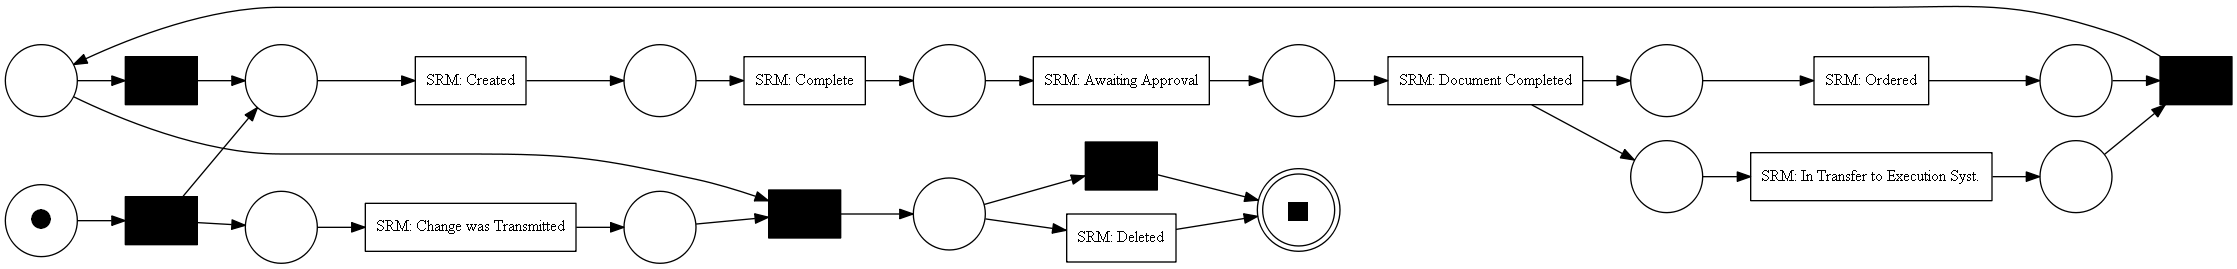

petriNet_srm.png






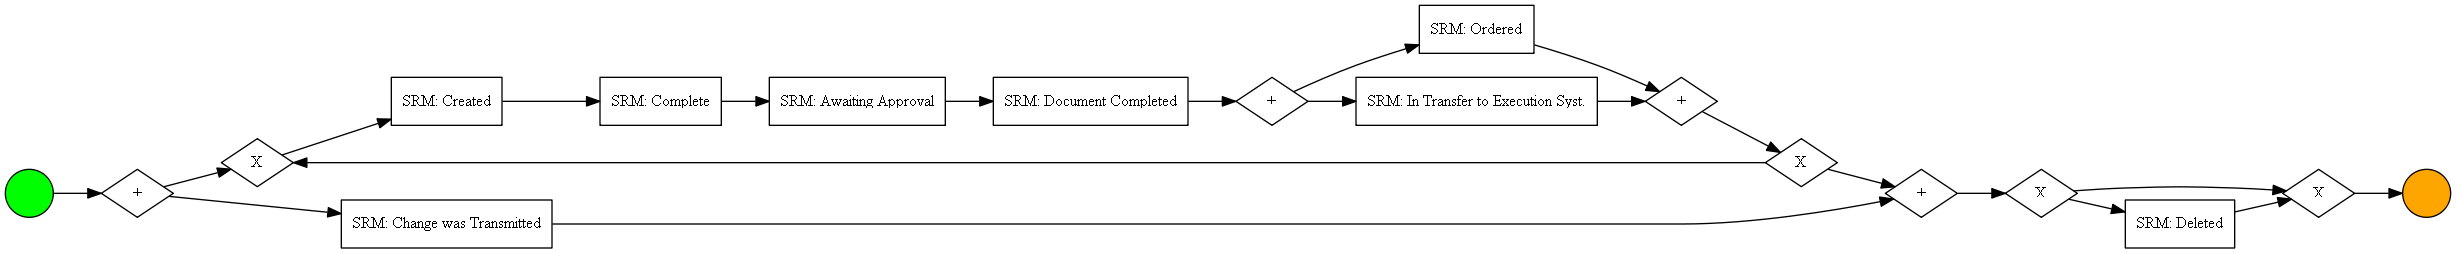

bpmn_srm.png






In [12]:
# mine the SRM process
mine_petri_net(log_srm, 0.2, "petriNet_srm.png")
mine_bpmn(log_srm, 0.2, "bpmn_srm.png")

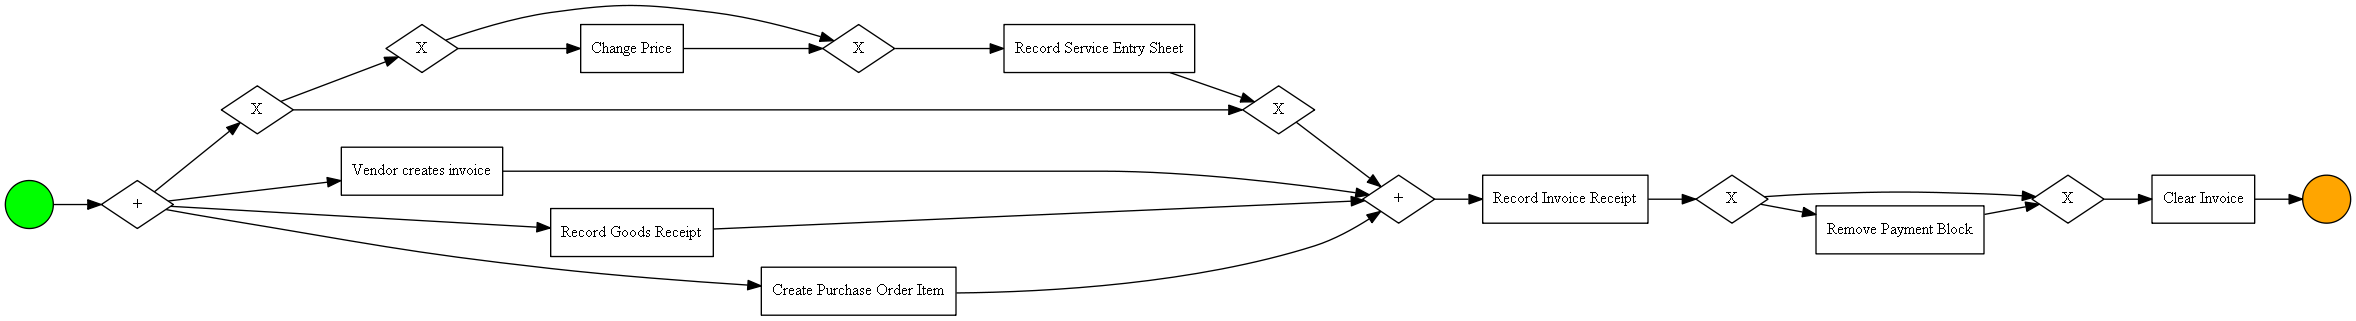

bpmn_ecPurchaseOrder.png






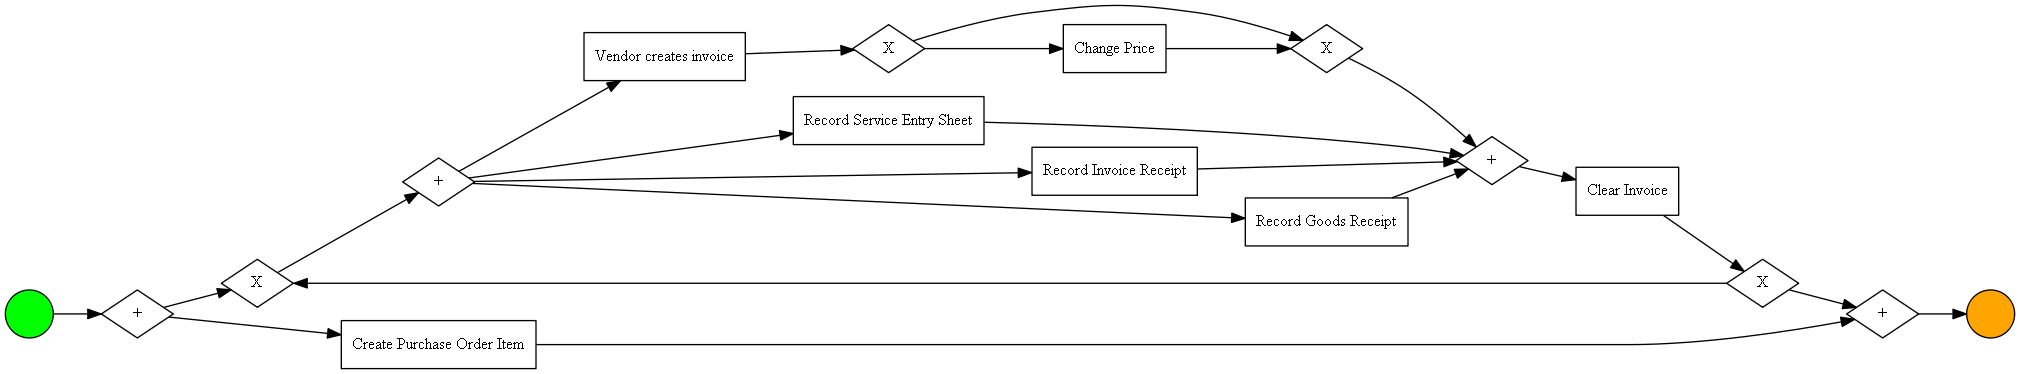

bpmn_frameworkOrder.png






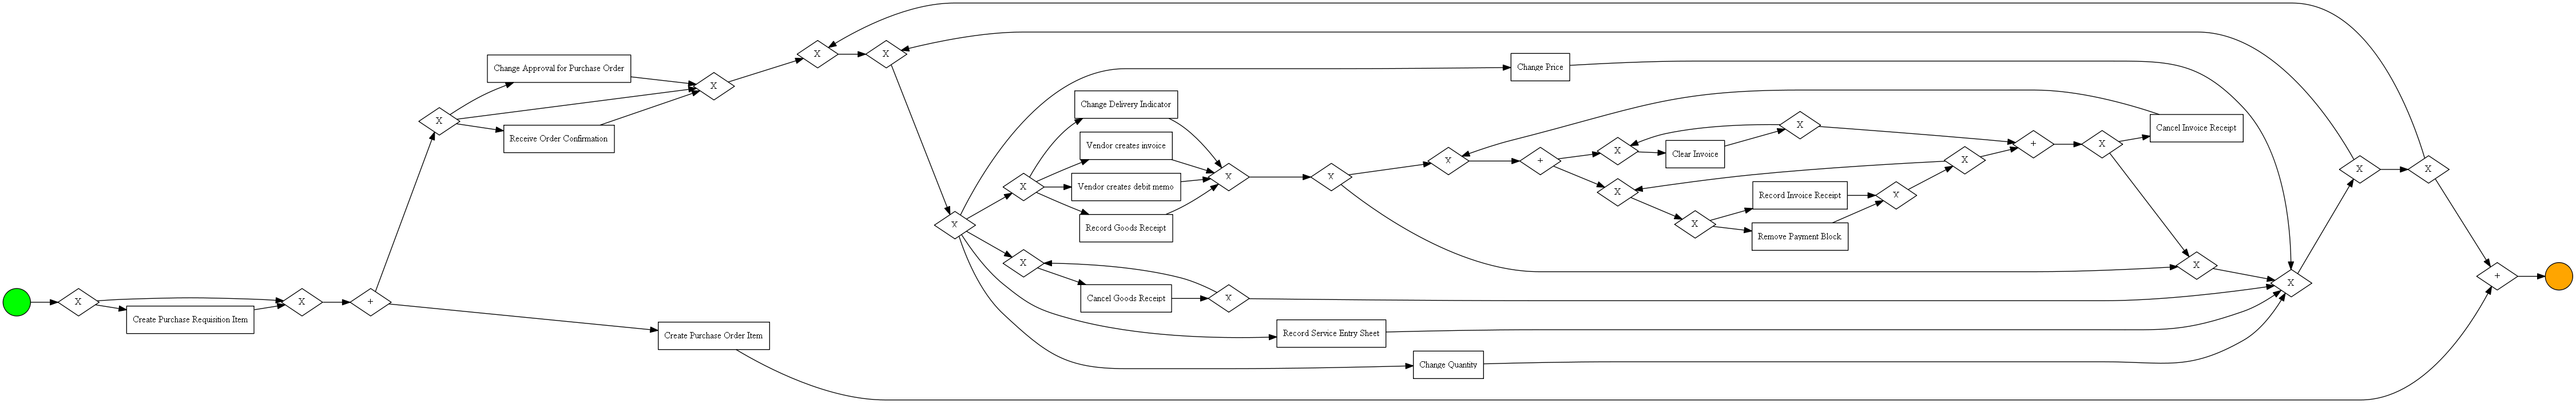

bpmn_standardPO.png






In [14]:
# Mine BPMN-Models
mine_bpmn(log_ecPurchaseOrder, 0.2, "bpmn_ecPurchaseOrder.png")
mine_bpmn(log_frameworkOrder, 0.2, "bpmn_frameworkOrder.png")
mine_bpmn(log_standardPO, 0.2, "bpmn_standardPO.png")